In [346]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [347]:
import numpy as np
import pandas as pd

In [348]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [349]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [350]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [351]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [352]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [353]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [354]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [355]:
# Gather table information
inspector = inspect(engine)
inspector.get_table_names()

# Get column names for table measurement
print('Measurement')
print('------')
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
print('')
print('Station')
print('------')
# Get column names for table station
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

Measurement
------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station
------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [356]:
# Get first row of data to understand what we are looking at
print('')
print('Measurement')
print('------')
measurement = Base.classes.measurement
measurementData = session.query(measurement).first()
print(measurementData.__dict__)
print('')
print('Station')
print('------')
station = Base.classes.station
stationData = session.query(station).first()
print(stationData.__dict__)




Measurement
------
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001B3B1679A88>, 'prcp': 0.08, 'id': 1, 'date': '2010-01-01', 'station': 'USC00519397', 'tobs': 65.0}

Station
------
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001B3B170C608>, 'name': 'WAIKIKI 717.2, HI US', 'longitude': -157.8168, 'id': 1, 'station': 'USC00519397', 'latitude': 21.2716, 'elevation': 3.0}


# Exploratory Climate Analysis

[]

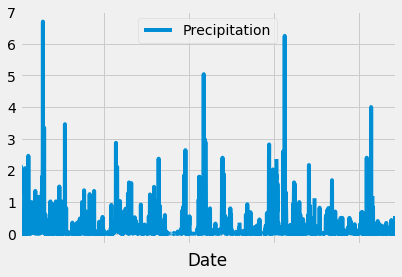

In [357]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the max date and one year back
endDate = session.query(measurement).order_by(measurement.date.desc()).first().date
endDate = dt.datetime.strptime(endDate, '%Y-%m-%d')
startDate = endDate - dt.timedelta(days=365)

# Filter based on time frame
rainData = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date < endDate.date()).\
    filter(Measurement.date > startDate.date()).\
    order_by(Measurement.date).\
    all()

# Create plot
df = pd.DataFrame(rainData, columns = ["Date", "Precipitation"])
df = df.plot(x="Date",y="Precipitation")
df.set_xlabel("Date")
df.set_xticklabels("")


In [358]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df = pd.DataFrame(rainData, columns = ["Date", "Precipitation"])
df.describe()

,Precipitation
count,2011.000000
mean,0.176549
std,0.460667
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [359]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station, Station.name).distinct(Station.station).count()


9

In [360]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationCounts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stationCountsDF = pd.DataFrame(stationCounts,columns = ["Station ID", "Times Shown"])
stationCountsDF

,Station ID,Times Shown
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [361]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
measurements = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*measurements).filter(Measurement.station == stationCountsDF.loc[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

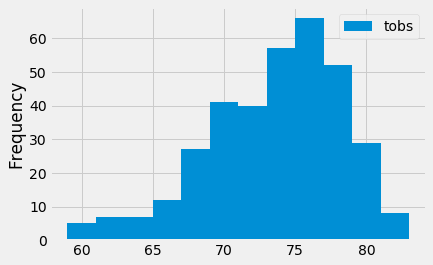

In [362]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

measurements = session.query(Measurement.tobs).\
    order_by(Measurement.tobs).\
    filter(Measurement.date < endDate.date()).\
    filter(Measurement.date > startDate.date()).\
    filter(Measurement.station==stationCountsDF.loc[0][0]).\
    order_by(Measurement.date).\
    all()
measurements = pd.DataFrame(measurements)
measurements.plot.hist(bins=12)

In [363]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [364]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tripTemps = calc_temps('2016-04-10','2016-04-15')


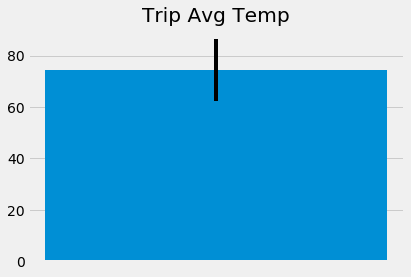

In [365]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
title = "Trip Avg Temp"
error = tripTemps[0][2] - tripTemps[0][0]
plt.bar(0, tripTemps[0][1], yerr=error, align='center')
plt.title(title)
plt.xticks([],[])
plt.show()

In [374]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
measurements = [Measurement.station, Station.name,\
                Station.latitude, Station.longitude,\
                Station.elevation,\
                func.avg(Measurement.prcp)]

measurements = session.query(*measurements).\
filter(Measurement.date < endDate).\
filter(Measurement.date > startDate).\
group_by(Measurement.station).\
order_by(func.avg(Measurement.prcp).desc()).all()

print(measurements)


[('USC00516128', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.44987767584097815), ('USC00519281', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.19441595441595355), ('USC00513117', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.14140350877192828), ('USC00514830', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.12571969696969695), ('USC00519523', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.12137380191693266), ('USC00517948', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.07649999999999993), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.044944134078212655)]


## Optional Challenge Assignment

In [375]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [368]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [369]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [370]:
# Plot the daily normals as an area plot with `stacked=False`
